<a href="https://colab.research.google.com/github/k2herat/ML_hse_homeworks/blob/main/homework_01_bvd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Машинное обучение, ФКН ВШЭ

## Домашнее задание 1. Разложение ошибки на смещение и разброс. Бэггинг, бустинг.

### Общая информация

Дата выдачи: 15.09.2025

Дедлайн: 23:59MSK 28.09.2025


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-16828617.py:2: SyntaxWarning: invalid escape sequence '\s'
  raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)


In [3]:
X = data
y = target

In [4]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) =
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] =
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [5]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

np.float64(34.9401918107675)

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка.

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$.

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$.

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [6]:
import numpy as np
from sklearn.base import clone
from collections import defaultdict

def compute_bias_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set of objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    :returns: bias (float), variance (float), error (float)
    each value is computed using bootstrap
    """
    n_obj = X.shape[0]

    oob_predictions = defaultdict(list)

    for _ in range(num_runs):
        bootstrap_indices = np.random.choice(n_obj, size=n_obj, replace=True)
        all_indices = set(range(n_obj))
        bootstrap_set = set(bootstrap_indices)
        oob_indices = list(all_indices - bootstrap_set)

        if len(oob_indices) == 0:
            continue

        current_regressor = clone(regressor)
        current_regressor.fit(X[bootstrap_indices], y[bootstrap_indices])
        oob_pred = current_regressor.predict(X[oob_indices])

        for idx, pred in zip(oob_indices, oob_pred):
            oob_predictions[idx].append(pred)
    valid_indices = [idx for idx in oob_predictions if len(oob_predictions[idx]) > 0]

    if len(valid_indices) == 0:
        return 0.0, 0.0, 0.0

    bias_sq = 0.0
    variance = 0.0
    error = 0.0

    for idx in valid_indices:
        preds = np.array(oob_predictions[idx])
        true_y = y[idx]

        mean_pred = np.mean(preds)
        bias_sq += (mean_pred - true_y) ** 2

        variance += np.var(preds, ddof=1)

        error += np.mean((preds - true_y) ** 2)
    n_valid = len(valid_indices)
    bias_sq /= n_valid
    variance /= n_valid
    error /= n_valid

    return bias_sq, variance, error

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import fetch_california_housing
from sklearn.base import clone
from collections import defaultdict

linear_reg = LinearRegression()
decision_tree = DecisionTreeRegressor(random_state=42, max_depth=5)
random_forest = RandomForestRegressor(random_state=42, n_estimators=50)

models = {
    'Linear Regression': linear_reg,
    'Decision Tree': decision_tree,
    'Random Forest': random_forest
}

results = {}
for name, model in models.items():
    print(f"\nВычисление для {name}")
    bias, variance, error = compute_bias_variance(model, X, y, num_runs=200)
    results[name] = {
        'bias': bias,
        'variance': variance,
        'error': error,
        'bias+variance': bias + variance
    }
    print(f"{name}:")
    print(f"  Смещение: {bias:.6f}")
    print(f"  Разброс: {variance:.6f}")

    print(f"  Ошибка: {error:.6f}")


Вычисление для Linear Regression
Linear Regression:
  Смещение: 23.884033
  Разброс: 0.982453
  Ошибка: 24.852958

Вычисление для Decision Tree
Decision Tree:
  Смещение: 11.691636
  Разброс: 9.705068
  Ошибка: 21.263208

Вычисление для Random Forest
Random Forest:
  Смещение: 10.608985
  Разброс: 2.305551
  Ошибка: 12.882599


__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

Да, как и на практике, сумма смещения и разброса примерно равна ошибке. То есть, всё также, как и должно было быть.


__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__

Случайный лес -- уже ансамбль, поэтому для него бэггинг не имеет смысла. Для линейной регрессии разброс ухудшился, так как присутствует большая корреляция алгоритмов. А вот для дерева уже всё работает лучше, так как разброс уменьшился в 5 раз почти.


In [9]:
from sklearn.ensemble import BaggingRegressor


bagging_models = {}
base_model_names = []

for name, model in models.items():
    if name != 'Random Forest':
        bagging_model = BaggingRegressor(
            estimator=clone(model),
            n_estimators=50,
            random_state=42,
            bootstrap=True
        )
        bagging_models[f'Bagging {name}'] = bagging_model
        base_model_names.append(name)


comparison_models = {**models, **bagging_models}

comparison_results = {}
for name, model in comparison_models.items():
    print(f"")
    bias, variance, error = compute_bias_variance(model, X, y, num_runs=100)
    comparison_results[name] = {
        'bias': bias,
        'variance': variance,
        'error': error
    }


for base_name in base_model_names:
    bagging_name = f'Bagging {base_name}'

    base_var = comparison_results[base_name]['variance']
    bagging_var = comparison_results[bagging_name]['variance']
    variance_reduction = base_var - bagging_var
    reduction_ratio = base_var / bagging_var if bagging_var > 0 else float('inf')

    print(f"\n{base_name}:")
    print(f"  Разброс базовой модели: {base_var:.6f}")
    print(f"  Разброс баггинг-модели: {bagging_var:.6f}")
    print(f"  Уменьшение разброса: {variance_reduction:.6f}")
    print(f"  Отношение разбросов: {reduction_ratio:.1f}x")

    if reduction_ratio > 1:
        print(f"  ✓ Баггинг уменьшил разброс в {reduction_ratio:.1f} раз")
    else:
        print(f"  ⚠ Баггинг не уменьшил разброс")









Linear Regression:
  Разброс базовой модели: 0.901953
  Разброс баггинг-модели: 1.018755
  Уменьшение разброса: -0.116802
  Отношение разбросов: 0.9x
  ⚠ Баггинг не уменьшил разброс

Decision Tree:
  Разброс базовой модели: 10.445462
  Разброс баггинг-модели: 2.160232
  Уменьшение разброса: 8.285230
  Отношение разбросов: 4.8x
  ✓ Баггинг уменьшил разброс в 4.8 раз


### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [13]:
from sklearn.base import clone

def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title="", ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))

    n_samples = X.shape[0]
    test_indices = np.random.choice(n_samples, size=num_test_objects, replace=False)
    train_indices = np.setdiff1d(np.arange(n_samples), test_indices)

    X_test = X[test_indices]
    y_test = y[test_indices]

    predictions_matrix = []

    for _ in range(num_runs):
        bootstrap_indices = np.random.choice(train_indices, size=len(train_indices), replace=True)
        current_model = clone(regressor)
        current_model.fit(X[bootstrap_indices], y[bootstrap_indices])
        preds = current_model.predict(X_test)
        predictions_matrix.append(preds)

    predictions_matrix = np.array(predictions_matrix)

    colors = plt.cm.Set3(np.linspace(0, 1, num_test_objects))

    for i in range(num_test_objects):
        x_positions = np.random.normal(i, 0.1, size=num_runs)
        ax.scatter(x_positions, predictions_matrix[:, i], alpha=0.7,
                  color=colors[i], s=40, label=f'Obj {i+1}')

        ax.axhline(y=y_test[i], xmin=i-0.4, xmax=i+0.4,
                  color='black', linewidth=3, linestyle='-')

    ax.set_xlabel('Test Objects')
    ax.set_ylabel('Predictions')
    ax.set_title(title)
    ax.set_xticks(range(num_test_objects))
    ax.set_xticklabels([f'{i+1}' for i in range(num_test_objects)])
    ax.grid(True, alpha=0.2)

    if num_test_objects <= 10:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    return ax

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

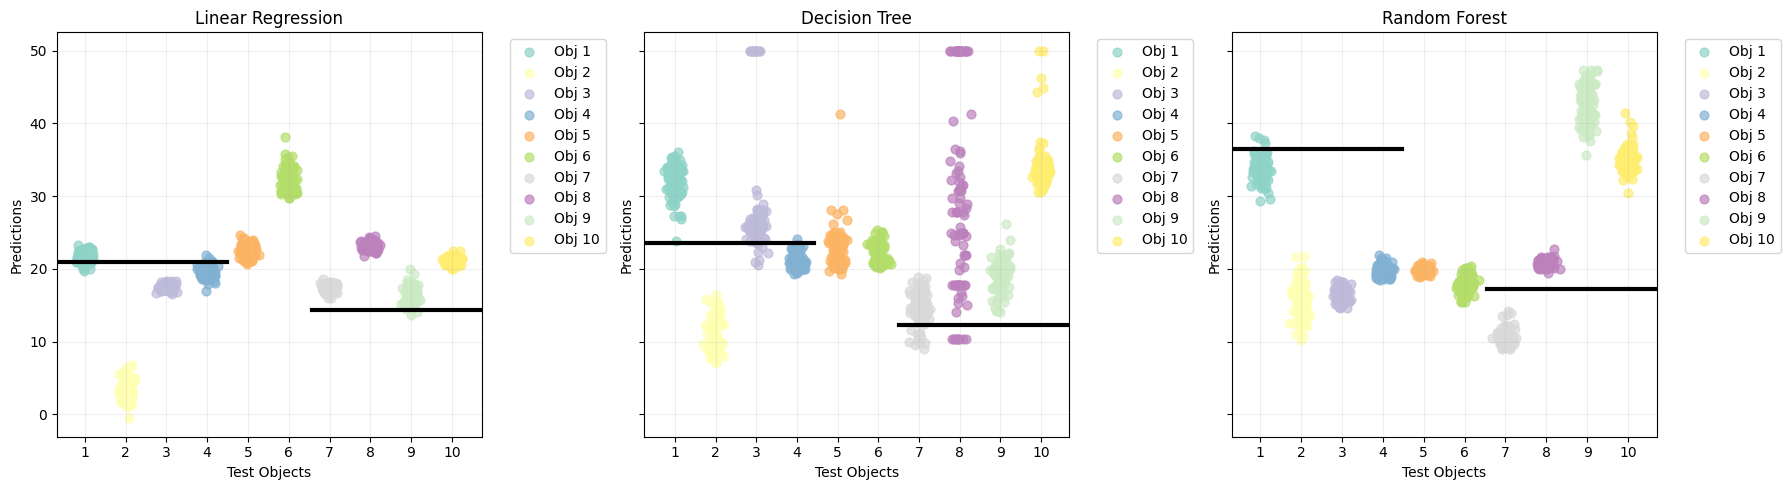

In [14]:
models = [
    ("Linear Regression", LinearRegression()),
    ("Decision Tree", DecisionTreeRegressor(max_depth=5, random_state=42)),
    ("Random Forest", RandomForestRegressor(n_estimators=50, random_state=42))
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, (name, model) in zip(axes, models):
    plot_predictions(model, X, y, ax=ax)
    ax.set_title(name)

plt.tight_layout()
plt.show()

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма.

__Your answer here:__

Лин рег: смещение большой, разброс маленький
Рф: всё маленькое
Дерево: смещение маленькое, разброс большой.


### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

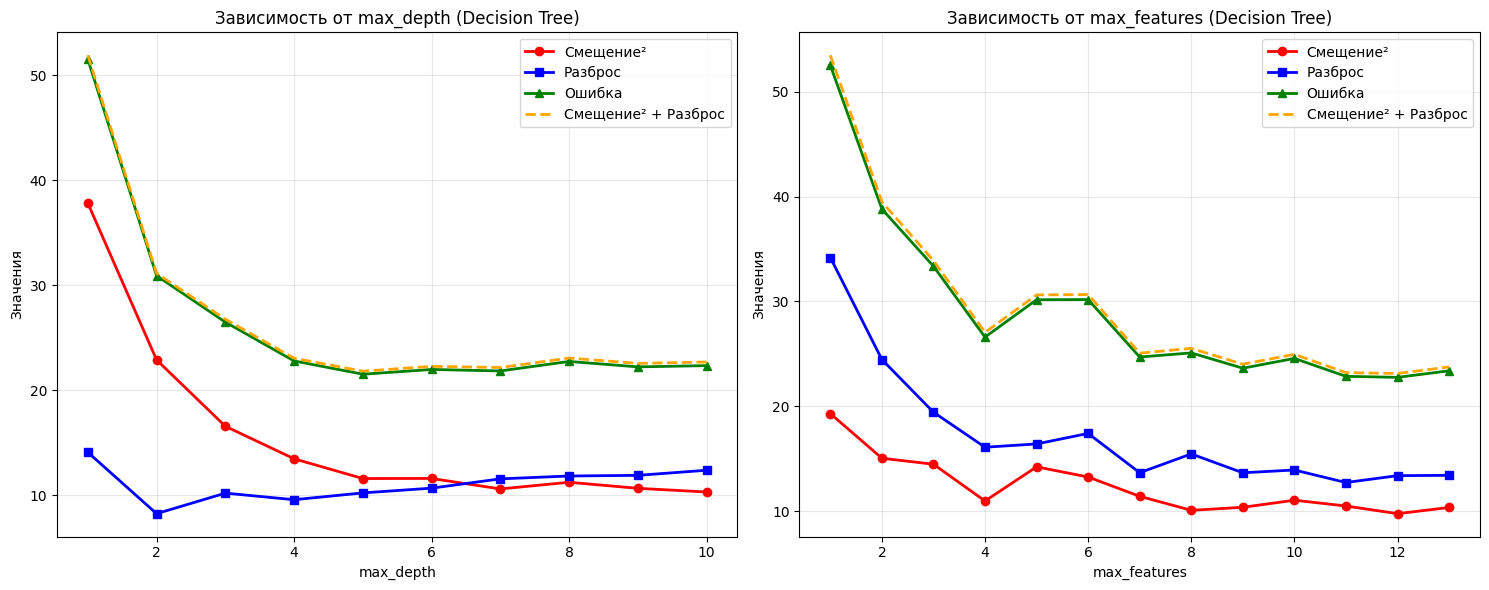

In [15]:
from sklearn.tree import DecisionTreeRegressor


max_depths = range(1, 11)
bias_depth = []
variance_depth = []
error_depth = []

for depth in max_depths:
    tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    bias, variance, error = compute_bias_variance(tree, X, y, num_runs=100)
    bias_depth.append(bias)
    variance_depth.append(variance)
    error_depth.append(error)

max_features_range = range(1, X.shape[1] + 1)
bias_features = []
variance_features = []
error_features = []

for n_features in max_features_range:
    tree = DecisionTreeRegressor(max_features=n_features, random_state=42)
    bias, variance, error = compute_bias_variance(tree, X, y, num_runs=100)
    bias_features.append(bias)
    variance_features.append(variance)
    error_features.append(error)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))


axes[0].plot(max_depths, bias_depth, 'o-', linewidth=2, label='Смещение²', color='red')
axes[0].plot(max_depths, variance_depth, 's-', linewidth=2, label='Разброс', color='blue')
axes[0].plot(max_depths, error_depth, '^-', linewidth=2, label='Ошибка', color='green')
axes[0].plot(max_depths, np.array(bias_depth) + np.array(variance_depth), '--',
            linewidth=2, label='Смещение² + Разброс', color='orange')
axes[0].set_xlabel('max_depth')
axes[0].set_ylabel('Значения')
axes[0].set_title('Зависимость от max_depth (Decision Tree)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)


axes[1].plot(max_features_range, bias_features, 'o-', linewidth=2, label='Смещение²', color='red')
axes[1].plot(max_features_range, variance_features, 's-', linewidth=2, label='Разброс', color='blue')
axes[1].plot(max_features_range, error_features, '^-', linewidth=2, label='Ошибка', color='green')
axes[1].plot(max_features_range, np.array(bias_features) + np.array(variance_features), '--',
            linewidth=2, label='Смещение² + Разброс', color='orange')
axes[1].set_xlabel('max_features')
axes[1].set_ylabel('Значения')
axes[1].set_title('Зависимость от max_features (Decision Tree)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

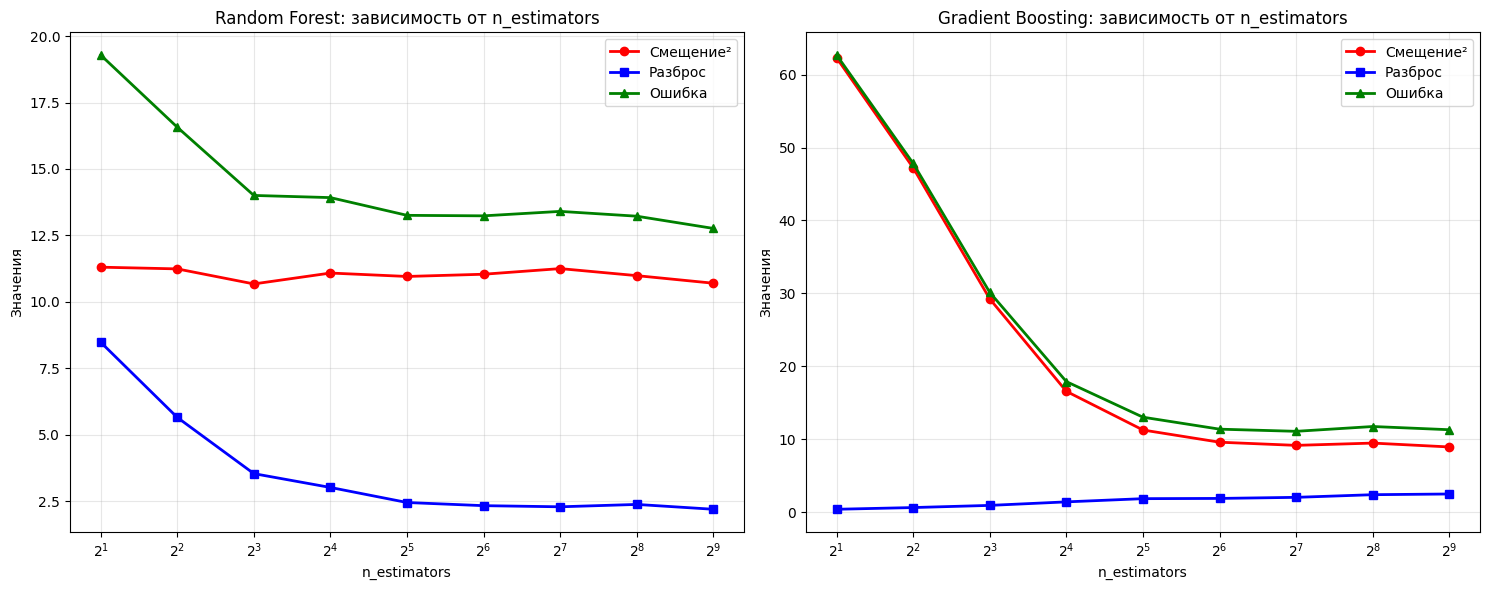

In [16]:
from sklearn.ensemble import GradientBoostingRegressor

n_estimators_grid = 2 ** np.arange(1, 10)
bias_rf = []
variance_rf = []
error_rf = []

for n_est in n_estimators_grid:
    rf = RandomForestRegressor(n_estimators=int(n_est), random_state=42)
    bias, variance, error = compute_bias_variance(rf, X, y, num_runs=50)
    bias_rf.append(bias)
    variance_rf.append(variance)
    error_rf.append(error)

bias_gb = []
variance_gb = []
error_gb = []

for n_est in n_estimators_grid:
    gb = GradientBoostingRegressor(n_estimators=int(n_est), random_state=42)
    bias, variance, error = compute_bias_variance(gb, X, y, num_runs=50)
    bias_gb.append(bias)
    variance_gb.append(variance)
    error_gb.append(error)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].plot(n_estimators_grid, bias_rf, 'o-', linewidth=2, label='Смещение²', color='red')
axes[0].plot(n_estimators_grid, variance_rf, 's-', linewidth=2, label='Разброс', color='blue')
axes[0].plot(n_estimators_grid, error_rf, '^-', linewidth=2, label='Ошибка', color='green')
axes[0].set_xlabel('n_estimators')
axes[0].set_ylabel('Значения')
axes[0].set_title('Random Forest: зависимость от n_estimators')
axes[0].set_xscale('log', base=2)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(n_estimators_grid, bias_gb, 'o-', linewidth=2, label='Смещение²', color='red')
axes[1].plot(n_estimators_grid, variance_gb, 's-', linewidth=2, label='Разброс', color='blue')
axes[1].plot(n_estimators_grid, error_gb, '^-', linewidth=2, label='Ошибка', color='green')
axes[1].set_xlabel('n_estimators')
axes[1].set_ylabel('Значения')
axes[1].set_title('Gradient Boosting: зависимость от n_estimators')
axes[1].set_xscale('log', base=2)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__

Глубина дерева:
Маленькая глубина — модель простая, стабильная, но грубо ошибается. Большая глубина — точнее, но непредсказуема. Ищем баланс.

Число признаков:
Мало признаков — модель случайная, много — стабильная, но может упускать важное. Обычно берут корень из общего числа.

Деревья в лесу:
Мало деревьев — предсказания "пляшут", много — стабилизируются. После 100-200 штук улучшения почти нет.

Деревья в бустинге:
Мало — модель "недоучена", много — точнее, но может переучить данные.

Я пытался вставить картинку, но у меня из-за неё чуть не завис коллаб, поэтому без картинки(